In [178]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
import pandas as pd
import quandl
import numpy as np
from datetime import date

### 数据集中有多个变量
* 日期（Date）
* 开盘价(Open)
* 最高价(High)
* 最低价(Low)
* 收盘价(Close)
* 总交易额(Volume)
* 营业额(turnover)


### 变量科普
* 开盘价和收盘价代表股票在某一天交易的起始价和最终价。
* 最高价、最低价和最后交易价表示当天股票的最高价、最低价和最后交易价格。
* 交易总量是指当天买卖的股票数量，而营业额(Lacs)是指某一特定公司在某一特定日期的营业额。要注意的另一点是，市场在周末和公共假期休市

* 损益的计算通常由股票当日的收盘价决定，因此我们将收盘价作为目标变量。让我们画出目标变量来理解它在我们的数据集中的分布
* 注意上表缺失了一些日期值为法定节假日。

In [199]:
start = date(2000,10,12)
end = date.today()
google_stock = pd.DataFrame(quandl.get("WIKI/GOOGL", start_date=start, end_date=end))
print(google_stock.shape)
google_stock.tail()
google_stock.head()

(3424, 12)


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


### 绘制股市历史收盘价趋势图

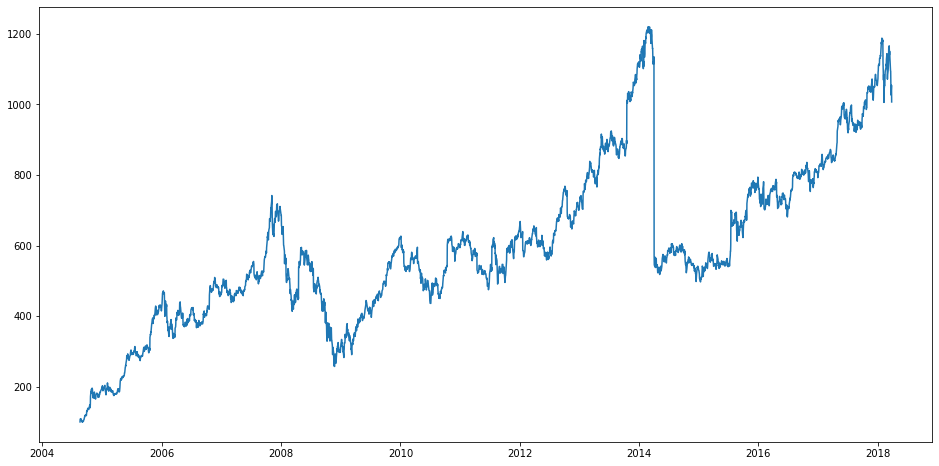

In [200]:
plt.figure(figsize=(16, 8))
plt.plot(google_stock['Close'])
plt.show()

### 构造训练集与验证集

In [201]:
# 时间点长度
time_stamp = 50

# 划分训练集与验证集
google_stock = google_stock[['Open', 'High', 'Low', 'Close', 'Volume']]  #  'Volume'
train = google_stock[0:2800 + time_stamp]
valid = google_stock[2800 - time_stamp:]

# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))  
scaled_data = scaler.fit_transform(train)
x_train, y_train = [], []


# 训练集
print(scaled_data.shape)
print(scaled_data[1, 3])
for i in range(time_stamp, len(train)):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i, 3])

x_train, y_train = np.array(x_train), np.array(y_train)

# 验证集
scaled_data = scaler.fit_transform(valid)
x_valid, y_valid = [], []
for i in range(time_stamp, len(valid)):
    x_valid.append(scaled_data[i - time_stamp:i])
    y_valid.append(scaled_data[i, 3])

x_valid, y_valid = np.array(x_valid), np.array(y_valid)

print(x_train.shape)
print(x_valid.shape)
train.head()


(2850, 5)
0.00740965576346235
(2800, 50, 5)
(624, 50, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0


### 创建并训练LSTM模型

In [202]:
# 超参数
epochs = 3
batch_size = 16
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim： 输入单个样本特征值的维度
# input_length： 输入的时间点长度
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=100, return_sequences=True, input_shape=(50, 5))`
  


Epoch 1/3
2800/2800 [==============================] - 25s 9ms/step - loss: 0.0037
Epoch 2/3
2800/2800 [==============================] - 20s 7ms/step - loss: 7.7309e-04
Epoch 3/3
2800/2800 [==============================] - 21s 7ms/step - loss: 7.2585e-04


### 预测股市价格

In [203]:
closing_price = model.predict(x_valid)
scaler.fit_transform(pd.DataFrame(valid['Close'].values))
# 反归一化
closing_price = scaler.inverse_transform(closing_price)
y_valid = scaler.inverse_transform([y_valid])
# print(y_valid)
# print(closing_price)
rms = np.sqrt(np.mean(np.power((y_valid - closing_price), 2)))
print(rms)
print(closing_price.shape)
print(y_valid.shape)

182.31521880433965
(624, 1)
(1, 624)


### 拟合股市趋势

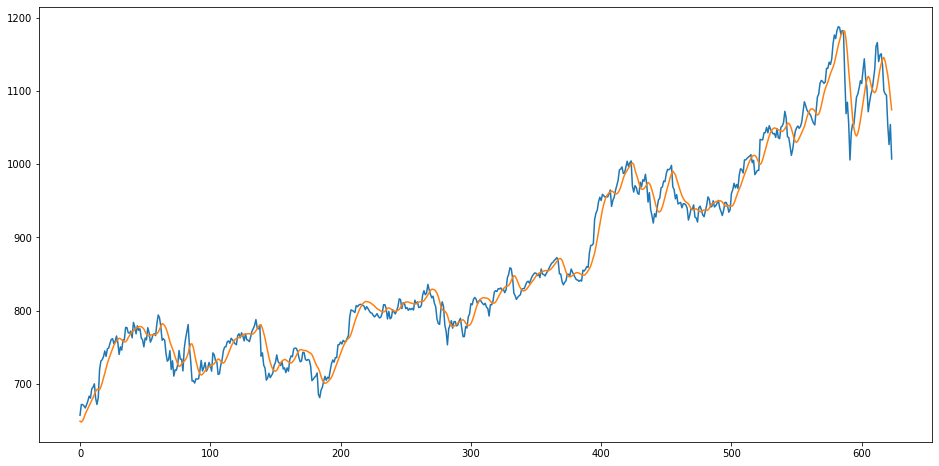

In [204]:
plt.figure(figsize=(16, 8))
dict_data = {
    'Predictions': closing_price.reshape(1,-1)[0],
    'Close': y_valid[0]
}
data_pd = pd.DataFrame(dict_data)

plt.plot(data_pd[['Close', 'Predictions']])
plt.show()